# Анализ проблем окупаемости рекламы для приложения Procrastinate Pro+.

Компания терпит убытки, несмотря на большие вложения в рекламу. Целью данного исследования является выявление причин этих убытков и разработка рекомендаций для выхода бизнеса в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 31 октября 2019 года:
1. лог сервера с данными об их посещениях,
2. выгрузка их покупок за этот период,
3. рекламные расходы.

Поставлены следующие задачи:
1. откуда приходят пользователи и какими устройствами они пользуются,
2. сколько стоит привлечение пользователей из различных рекламных каналов;
3. сколько денег приносит каждый клиент,
4. когда расходы на привлечение клиента окупаются,
5. какие факторы мешают привлечению клиентов.

## Загрузка данных и подготовка их к анализу

Импортируем библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

Загружаем данные о визитах, заказах и расходах в соответствующие переменные.

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv') #визиты

In [3]:
orders = pd.read_csv('/datasets/orders_info_short.csv') #заказы

In [4]:
costs = pd.read_csv('/datasets/costs_info_short.csv') #расхды

Приводим названия столбцов к змеиному регистру.

In [6]:
visits = visits.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device','Channel':'channel', 'Session Start':'session_start', 'Session End':'session_end'})

In [7]:
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [8]:
orders.columns = ('user_id', 'event_dt', 'revenue')

In [9]:
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [10]:
costs.columns = costs.columns.str.lower()

In [11]:
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

Проверяем ДФ на наличие дубликатов.

In [12]:
visits.duplicated().sum()

0

In [13]:
orders.duplicated().sum()

0

In [14]:
costs.duplicated().sum()

0

Дубликатов нет ни в одном из исследуемых дф. Теперь посмотрим на типы данных и приведем к нужному, если это необходимо.

In [15]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [16]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [17]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим, есть ли в дф пропущенные значения

In [18]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [19]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [20]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

Пропуски во всех дф отсутствуют.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии


`Функция для расчета Retention Rate`.

In [21]:
def get_retention(profiles, 
                  visits, 
                  observation_date, 
                  horizon_days, 
                  dimensions=[], 
                  ignore_horizon=False):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(visits[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, 
                                columns='lifetime', 
                                values='user_id', 
                                aggfunc='nunique')
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time

`Функция для расчета Conversion Rate`. 

In [22]:
def get_conversion(profiles,
                   orders,
                   observation_date,
                   horizon_days,
                   dimensions=[],
                   ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_orders = (orders.sort_values(by=['user_id', 'event_dt'])
                    .groupby('user_id')
                    .agg({'event_dt': 'first'})
                    .reset_index())
    result_raw = result_raw.merge(first_orders[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions: 
        dimensions = []
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time   

`Функция для расчета LTV и ROI`.

In [23]:
def get_ltv(profiles,
            orders,
            observation_date,
            horizon_days,
            dimensions=[],
            ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (cac.groupby(dims)
               .agg({'acquisition_cost': 'mean'})
               .rename(columns={'acquisition_cost': 'cac'}))
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    return (result_raw,
        result_grouped,
            result_in_time, 
            roi_grouped,
            roi_in_time)

`Функция для визуализации пожизненной ценности и окупаемости`

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

`Функция для визуализации удержания`

In [25]:
def plot_retention(retention, retention_history, horizon):
    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    plt.tight_layout()

    plt.show()

`Функция для визуализации конверсии`

In [26]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

`Функция для сглаживания датафрейма`

In [27]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

`Функция для определения профилей пользователей`

In [28]:
def get_profiles(sessions, orders, costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first',
             'channel': 'first',
             'device': 'first',
             'region': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index() 
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  
    )
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

## Исследовательский анализ данных

Посмотрим на минимульную и максимальную дату привлечения пользователей.

In [29]:
profiles = get_profiles(visits, orders, costs)
display(profiles['first_ts'].min())
display(profiles['first_ts'].max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

Для дальнейшего анализа напишем функцию, с помощью которой создадим профили пользователей. Результат сохраним в переменную `profiles`, в котрой будут храниться данные о дате первого посещения, стране, девайсе, источнике перехода в приложение, а также информация о покупках.

In [30]:
def get_profiles(visits, orders):
    profiles = (visits.sort_values(by=['user_id', 'session_start'])
            .groupby('user_id')
            .agg({'session_start': 'first',
                 'region':'first',
                 'device':'first',
                 'channel':'first'})
           .reset_index())
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    profiles['dt'] = profiles['session_start'].dt.date
    profiles['month'] = profiles['session_start'].astype('datetime64[M]')
    return profiles
profiles = get_profiles(visits, orders)
profiles.head(4)

,user_id,session_start,region,device,channel,payer,dt,month
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,True,2019-05-07,2019-05-01
1,4919697,2019-07-09 12:46:07,United States,iPhone,FaceBoom,False,2019-07-09,2019-07-01
2,6085896,2019-10-01 09:58:33,France,iPhone,organic,False,2019-10-01,2019-10-01
3,22593348,2019-08-22 21:35:48,Germany,PC,AdNonSense,False,2019-08-22,2019-08-01


Посмотрим, из каких стран приходят пользователи, на какую страну приходится больше всего платящих пользователей, а также долю платящих пользователей.

In [31]:
(profiles.groupby('region')
.agg({'payer':'mean', 'user_id':'count'})
.reset_index()
.sort_values(by='user_id', ascending=False))

,region,payer,user_id
3,United States,0.069019,100002
2,UK,0.039829,17575
0,France,0.037994,17450
1,Germany,0.041119,14981


Из таблицы видно, что пользователи прихоядт из США, Великобритании, Франции и Германии. Наибольшее количество платящих пользователей приходит из США.

Посмотрим на устройства, которыми пользуются клиенты и что предпочитают платящие пользователи.

In [32]:
(profiles.groupby('device')
.agg({'payer':['mean', 'count']}).reset_index())

device     payer       
                mean  count
0  Android  0.058518  35032
1      Mac  0.063644  30042
2       PC  0.050468  30455
3   iPhone  0.062079  54479

В приложение пользователи заходят через iphone, android, pc, mac. Больше всего клиентов использует iphone, но наибольшая доля платящих пользователей использует mac.

Теперь посмотрим на источники привлечения и определим каналы, из которых приходят платящие пользователи.

In [33]:
(profiles.groupby('channel')
.agg({'user_id':'count', 'payer':'mean'})
.reset_index().sort_values(by='payer', ascending=False))

,channel,user_id,payer
1,FaceBoom,29144,0.122049
0,AdNonSense,3880,0.113402
9,lambdaMediaAds,2149,0.104700
6,TipTop,19561,0.096007
5,RocketSuperAds,4448,0.079137
7,WahooNetBanner,8553,0.052964
8,YRabbit,4312,0.038265
3,MediaTornado,4364,0.035747
2,LeapBob,8553,0.030633
4,OppleCreativeMedia,8605,0.027077


Наибольшая доля платящих пользователей приходится на FaceBoom, AdNonSense, lambdaMediaAds, TipTop и RocketSuperAds.

`ВЫВОД`

Пользователи прихоядт из США, Великобритании, Франции и Германии. Наибольшее количество платящих пользователей приходит из США. Используемые девайсы: iphone, android, pc, mac. Больше всего клиентов использует iphone, но наибольшая доля платящих пользователей использует mac. Каналы для привлечения: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds, WahooNetBanner, YRabbit, MediaTornado, LeapBob, OppleCreativeMedia, organic. Наибольшая доля платящих пользователей приходится на FaceBoom (0.122), AdNonSense(0.113), lambdaMediaAds(0.105), TipTop(0.096) и RocketSuperAds(0.0791).

## Маркетинг

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам, по времени (помесячно).Визуализируем результаты.

In [34]:
costs['costs'].sum().round(2) #общая сумма расходов на маркетинг

105497.3

In [35]:
rasx = costs.groupby('channel').agg({'costs':'sum'}).reset_index().sort_values(by='costs', ascending=False)
rasx['share'] = (rasx['costs'] /costs['costs'].sum() * 100).round(2)
rasx
#общая сумма расходов для каждого источника привлечения и процент затрат каждого канала от общей суммы

,channel,costs,share
6,TipTop,54751.30,51.90
1,FaceBoom,32445.60,30.75
7,WahooNetBanner,5151.00,4.88
0,AdNonSense,3911.25,3.71
4,OppleCreativeMedia,2151.25,2.04
5,RocketSuperAds,1833.00,1.74
2,LeapBob,1797.60,1.70
9,lambdaMediaAds,1557.60,1.48
3,MediaTornado,954.48,0.90
8,YRabbit,944.22,0.90


In [36]:
costs['month'] = costs['dt'].astype('datetime64[M]') #добавляем новый столбец с номером месяца

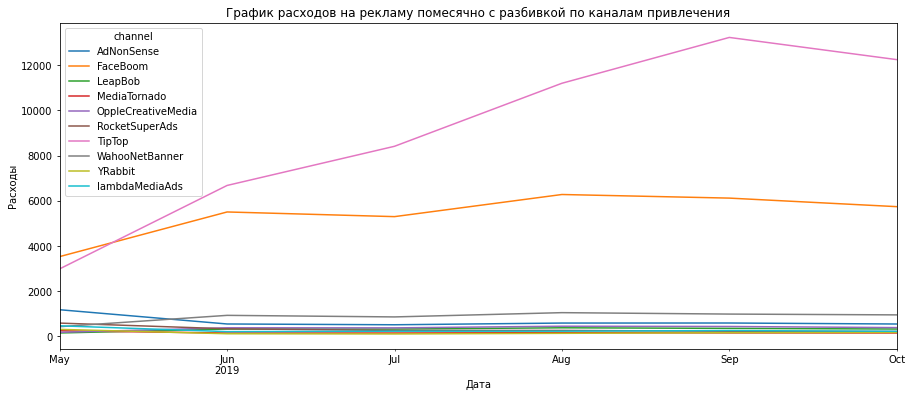

In [37]:
costs.pivot_table(values='costs',index='month',columns='channel',aggfunc='sum').plot(figsize=(15,6))
plt.title('График расходов на рекламу помесячно с разбивкой по каналам привлечения')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()
#сумма расходов для каждого источника привлечения помесячно

`График показывает, что основные траты рекламного бюджета приходятся на два канала привлечения: TipTop и FaceBoom.`

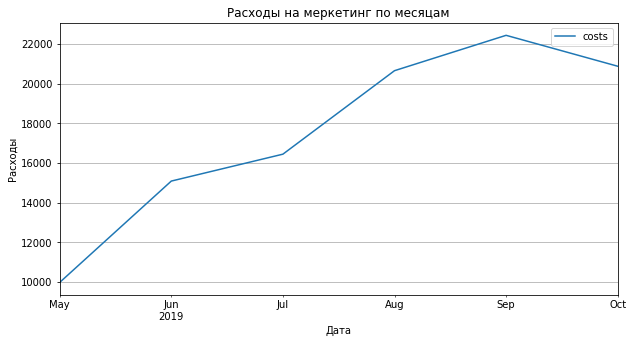

In [38]:
costs.pivot_table(values='costs', index='month', aggfunc='sum').plot(figsize=(10,5), grid=True)
plt.title('Расходы на меркетинг по месяцам')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

`До сентрября траты на маркетинг постоянно росли и достигли своего максимума в этом месяце. К октябрю они начали снижаться.`

Рассчитаем средний САС на одного пользователя для всего проекта и для каждого источника трафика. Для этого будем использовать профили пользователей и доработанную функцию `get_profiles`.

In [39]:
def get_profiles(sessions, orders, costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first',
             'channel': 'first',
             'device': 'first',
             'region': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index() 
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  
    )
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

In [40]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [41]:
profiles = profiles.query('channel != "organic"')
profiles['acquisition_cost'].mean().round(3) 
#средняя стоимость привлечения одного пользователя для всего проекта

1.127

Построим сводную таблицу, чтобы посмотреть, сколько стоило привлечение одного пользователя для каждого источника.

In [42]:
profiles.pivot_table(values='acquisition_cost',
                     index ='channel',
                     aggfunc='mean')

,acquisition_cost
channel,
AdNonSense,1.008054
FaceBoom,1.113286
LeapBob,0.210172
MediaTornado,0.218717
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
TipTop,2.799003
WahooNetBanner,0.602245
YRabbit,0.218975


Визуализируем результат.

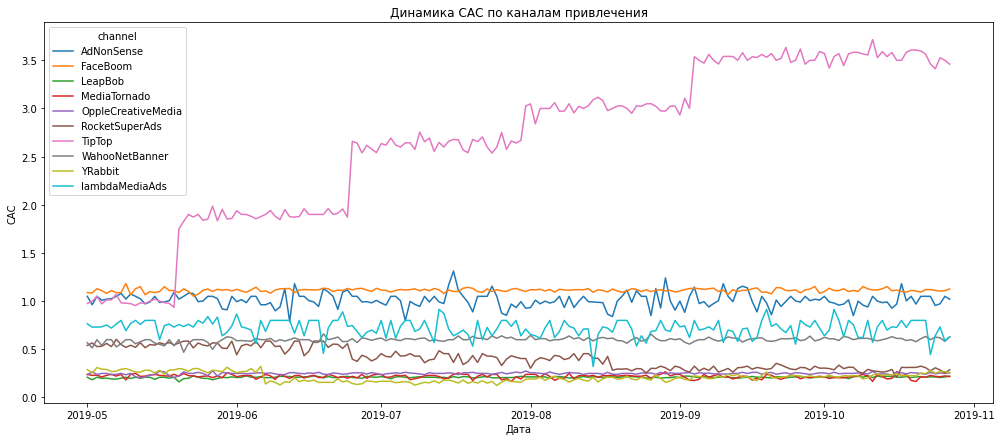

In [43]:
profiles.pivot_table(values='acquisition_cost',
                     columns ='channel',
                     index = 'dt',
                     aggfunc='mean').plot(figsize=(17,7))
plt.title('Динамика САС по каналам привлечения')
plt.xlabel('Дата')
plt.ylabel('CAC')
plt.show()

`На графике четко видно, что рекламные траты на канал TipTop с каждым месяцем становятся все больше.Траты на все остальные каналы остаются стабильными.`

`ВЫВОД`

Общая сумма расходов на маркетинг составила 105497.3. На сентябрь пришлись самые крупные траты на маркетинг. Если говорить о каналах привлечения, то наибольшие затраты пришлись на два канала: TipTop (54751.30) и FaceBoom(32445.60). Средняя стоимость привлечения одного пользователя для всего проекта составляет 1.127. Самая высокая стоимость привлечения одного пользователя приходится на канал TipTop и с каждым месяцем эта стоимость увеличивается. У всех остальных каналов средняя стоимость привлечения пользователя в среднем держится на одном уровне.

## Окупаемость рекламы для привлечения пользователей

Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

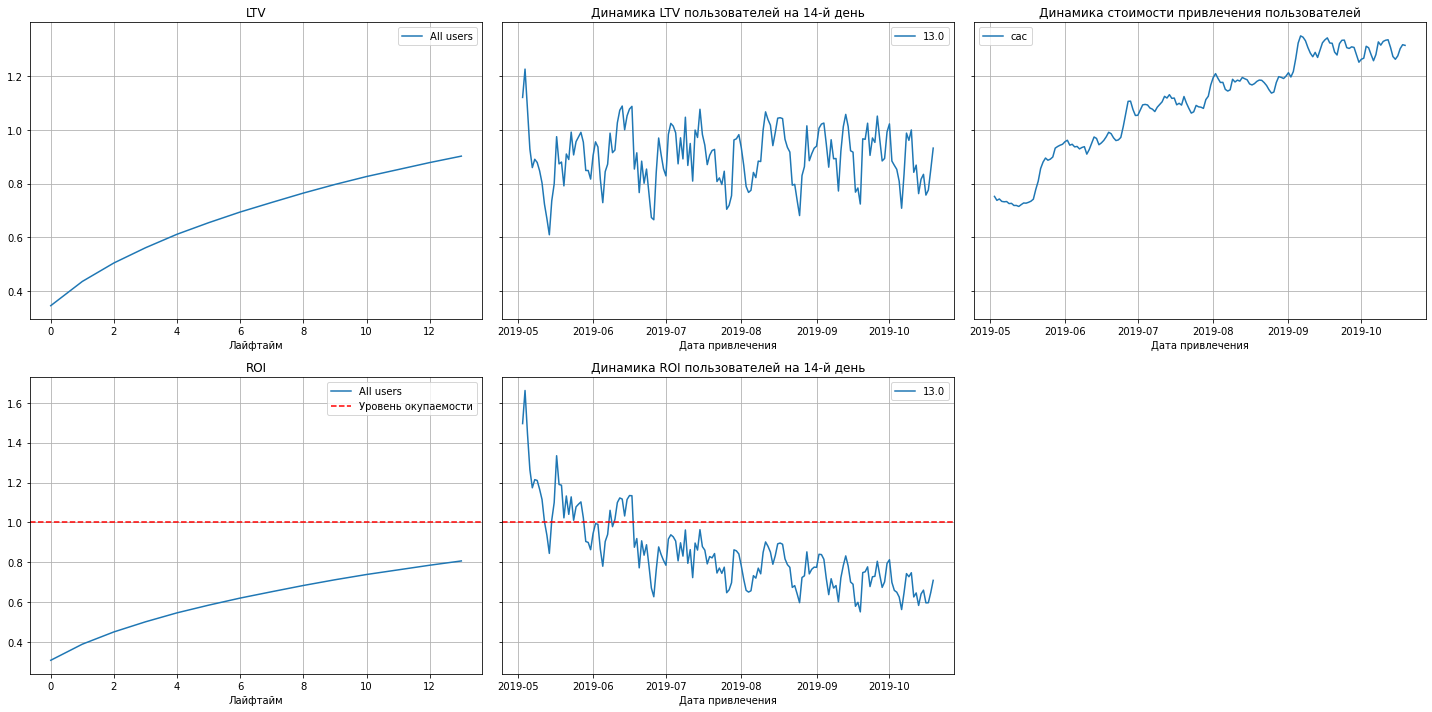

In [44]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019,11, 1).date(), 14, dimensions=[]
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history,14, window=3) 

`LTV стабилен, но реклама не окупается, хотя стоимость привлечения пользователей с каждым месяцем растет.`

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

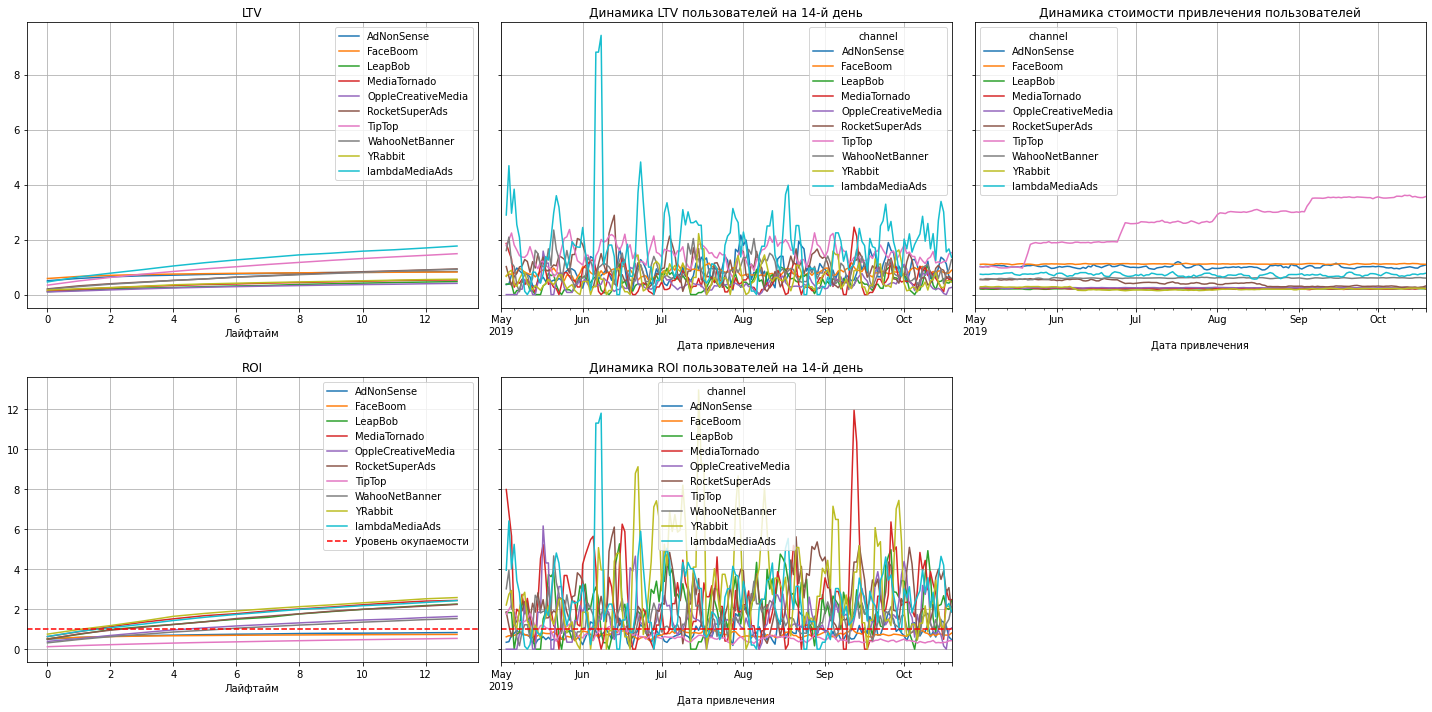

In [45]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history,14, window=3)

`LTV растет не по всем каналам. Некоторые рекламные каналы не окупаются, в том числе и TipTop, на рекламу которого привлекается наибольшее количество ресурсов.FaceBoom тоже не окупается, хотя по количеству инвестиций он на втором месте.`

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

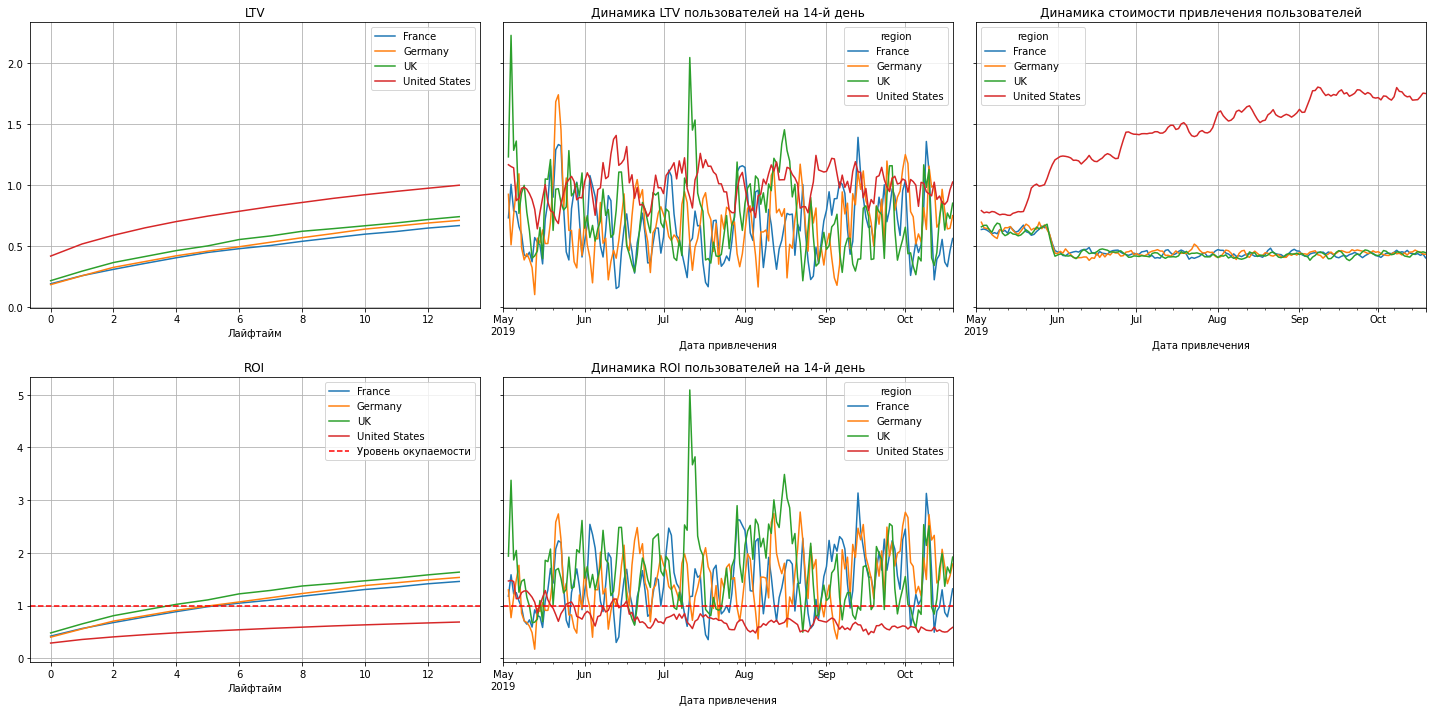

In [46]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history,14, window=3)

`Самый высокий LTV у пользователей из США, также , как и инвестиции в маркетинг для этих пользователей. Но эти инвестиции не окупаются. С пользователями из Франции, Германии и Великобритании такой проблемы нет.`

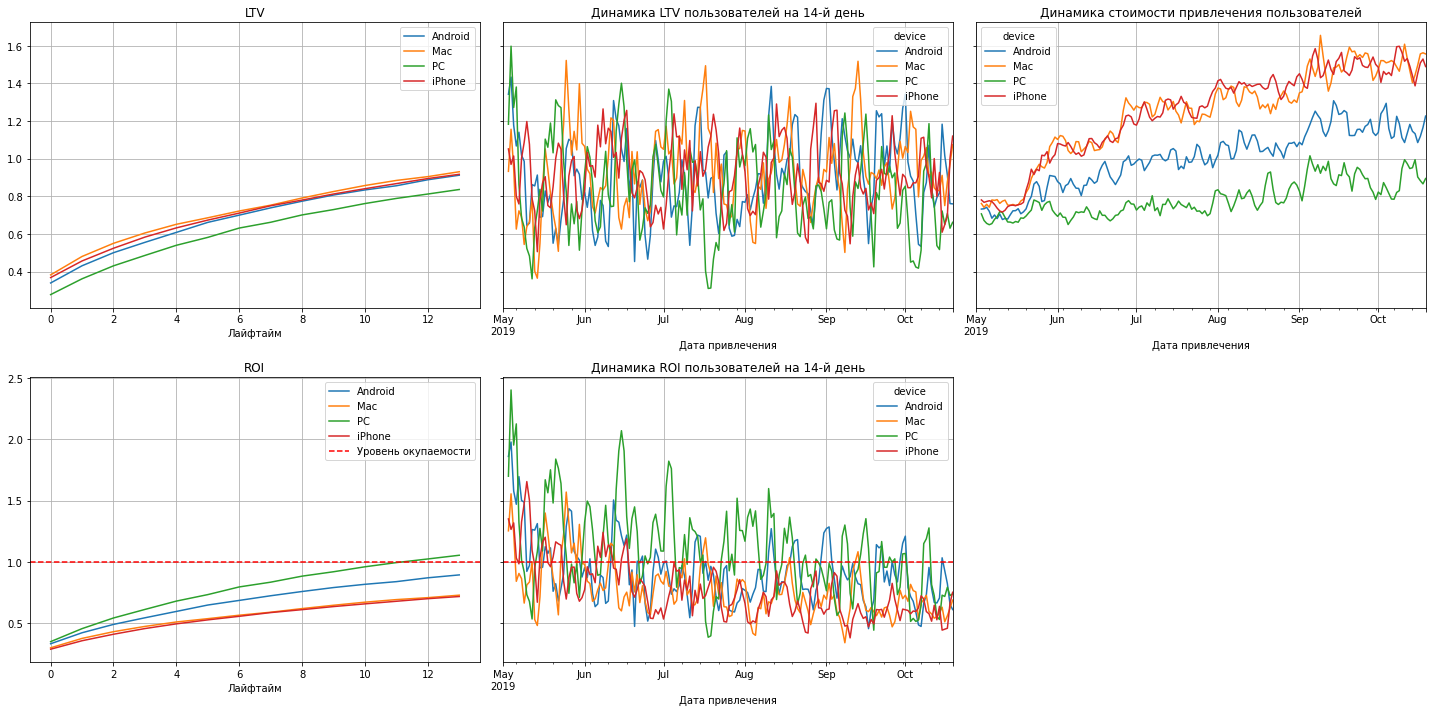

In [47]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history,14, window=3)

`При постоянно растущих затратах на маркетинг, окупаются только пользователи РС. LTV для всех пользователей стабилен.`

`ВЫВОД`

Общая картина следующая: LTV растет, что хорошо, но реклама не окупается.В динамике окупаемость инвестиций падает. Стоимость привлечения пользователей растет.

Не окупаются следующие каналы привлечения: TipTop, FaceBoom, AdNoneSense. Также не окупается привлечение пользователей из США. если говорить про устройства, то не окупается реклама для Android, Mac, iphone.

При этом затраты на маркетинг с разбивкой по используемому девайсу растут ежемесячно. Расходы на неокупающихся пользователей из США тоже растут, а для остальных стран с июня инвестиций стало меньше, хотя именно эти страны окупаются. 

Построим графики конверсии с разбивкой по устройствам, странам, рекламным каналам.

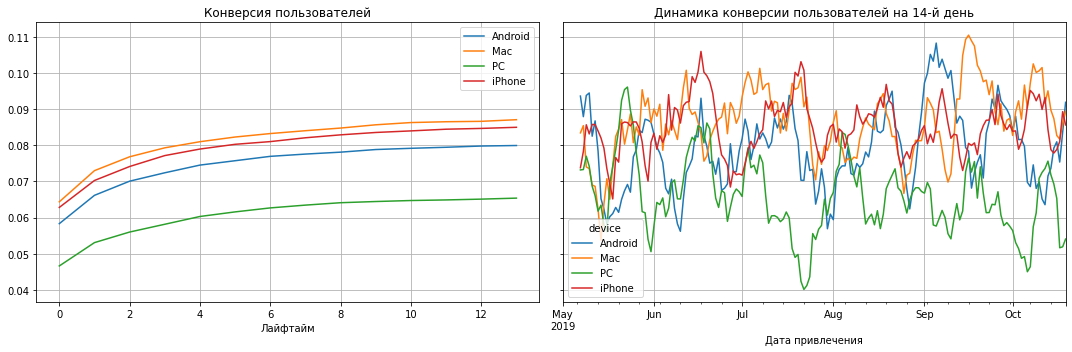

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])
plot_conversion(conversion_grouped, conversion_history, 14) 

`Конверсия для PC самая низкая, остальные пользователи конвертируются хорошо.`

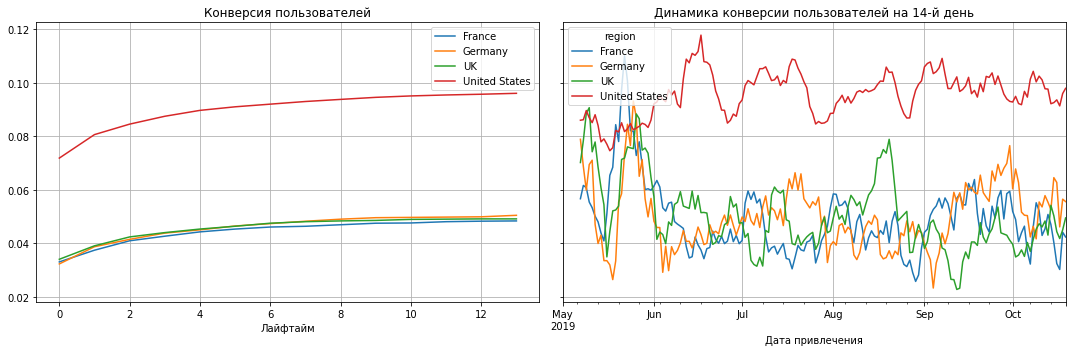

In [49]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])
plot_conversion(conversion_grouped, conversion_history, 14) 

`Пользователи из США отлично конвертируются, что нельзя сказать о всех остальных странах.`

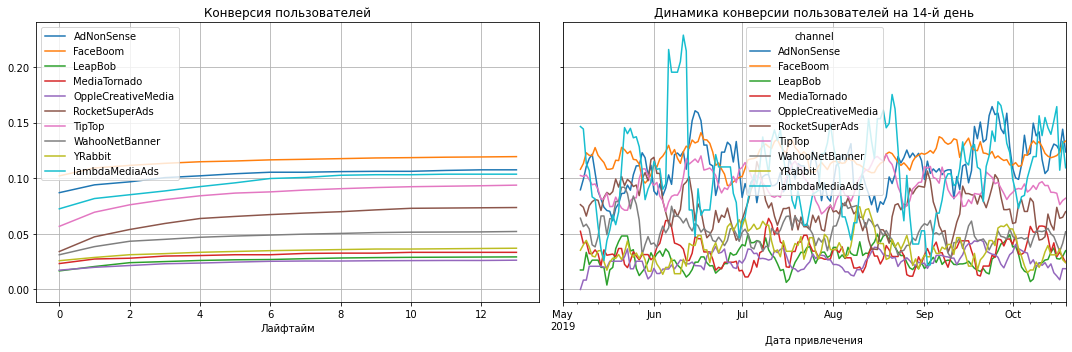

In [50]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, 14) 

`Низкая конверсия у следующих каналов: RocketSuperAds, WahooNetBanner, YRabbit, MediaTornado, LeapBob, OppleCreativeMedia. Лучше всего конвертируются пользователи из канала FaceBoom.`

`ВЫВОД`

Пользователи РС конвертируются хуже всего, с остальными устройствами такой проблемы нет. 
Пользователи из США конвертируются лучше всех пользователей из других стран.
Лучше всего всего конвертируются пользователи из канала FaceBoom. Пользователи из TipTop конвертируются неплохо, но если учесть тот факт, что на их привлечение тратится самая большая сумма денег. Стоит задуматься.Низкая конверсия у следующих каналов: RocketSuperAds, WahooNetBanner, YRabbit, MediaTornado, LeapBob, OppleCreativeMedia.


Построим графики удержания с разбивкой по устройствам, странам, рекламным каналам.

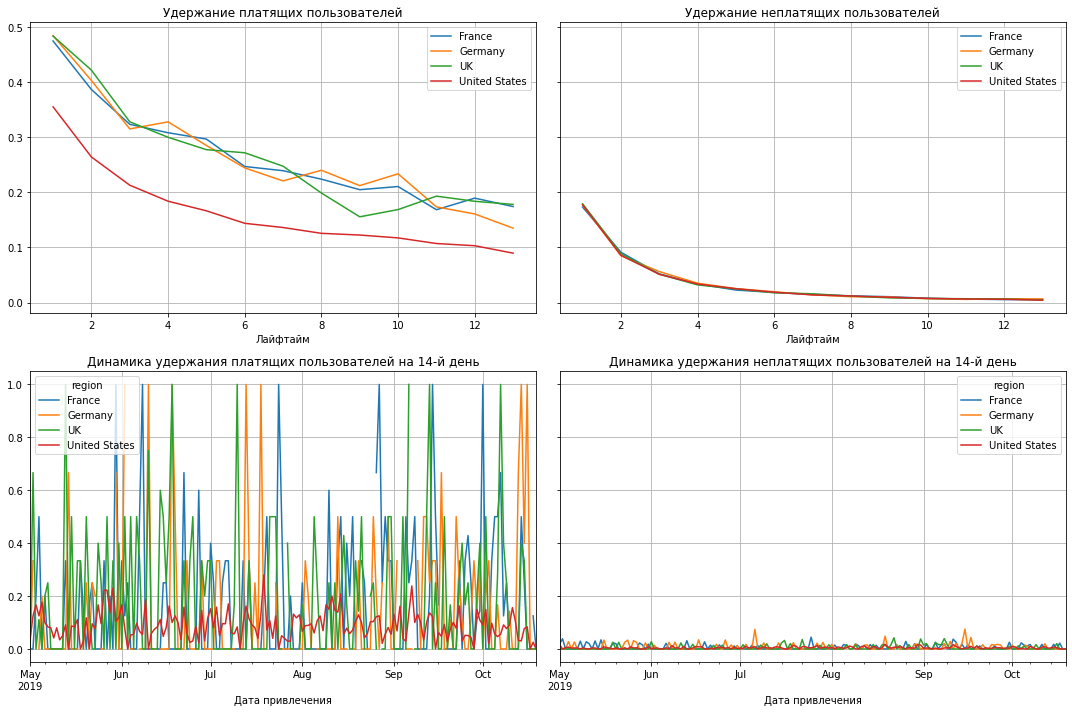

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, 14) 

`Хуже всего удерживаются платящие пользователи из США.`

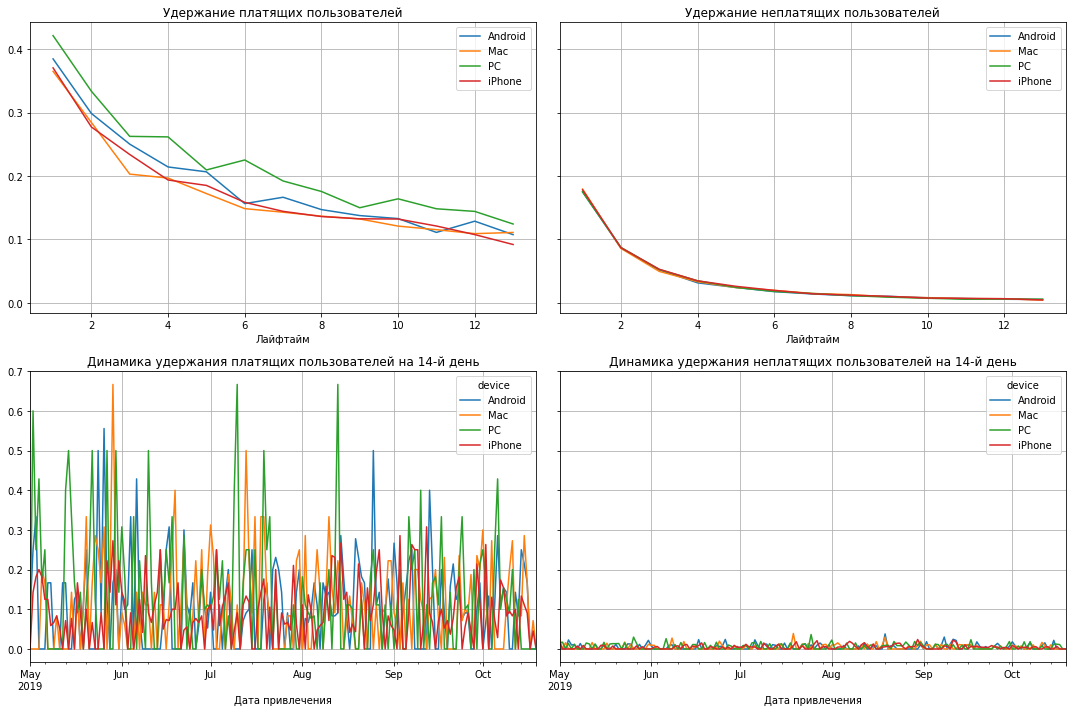

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, 14) 

`В целом удержание всех платящих пользователей хорошее, но у PC оно чуть лучше.`

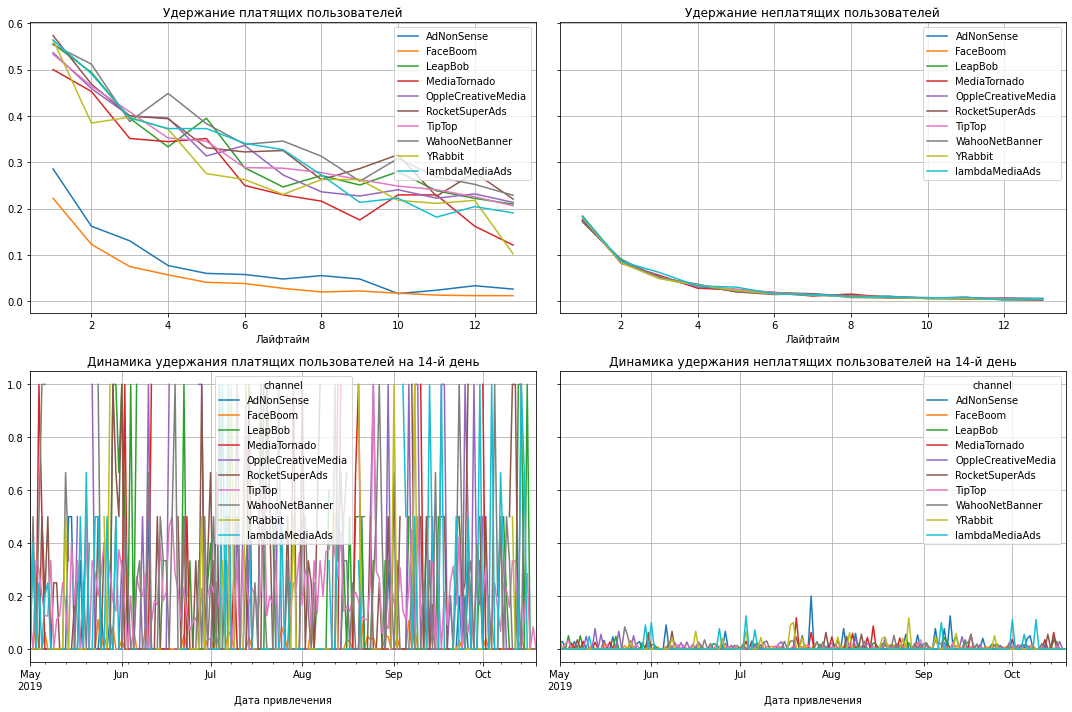

In [53]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, 14) 

`Есть два канала с самым плохим удержанием: FaceBoom и AdNoneSense. Удержание всех остальных каналов намного лучше.`

`ВЫВОД`

Платящие пользователи из США удерживаются хуже всего. Хотя конверсия пользователей РС самая низкая, но вот удержание таких пользоватлей лучше всего. Удержание пользователей из канала FaceBoom самое низкое, хотя конверсия очень хорошая, также низкое удержание у пользователей из канала AdNoneSense. С остальными каналами проблемы с удержанием нет. 

## Выводы и рекомендации

`Подводя итог, можно выделить несколько проблем`:
1. Самое большое количество инвестиций приходится на канал привлечения TipTop, но это инвестиции не окупаются. При этом конверсия пользователей хорошая. Плохо удерживаются польхователи из каналов FaceBoom и AdNoneSense. 
2. Самая высокая стоимость привлечения приходится на пользователей из США, но опять эти инвестиции не окупаются. При этом пользователи из США конвертируются лучше всего, но удержание пользователей из этой страны самое низкое.
3. Есть проблемы с используемыми девайсами. Инвестиций с каждым месяцем становится больше, но окупаются только пользователи РС. При этом конверсия у РС самая низкая. С удержанием явнымх проблем не выявлено.

`Рекомендации`:

Есть смысл перераспределить количество инвестиций. 
1. Есть несколько каналов, инвестиции в которые окупаются и нет проблем удержанием. Это каналы LeapBob, MediaTornado, OppleCreativeMedia, WahooNetBanner, YRabbit, lambdaMediaAds,RocketSuperAds.Стоит обратить на них внимание.
2. Инвестиции в США не окупаются, в отличие от инвестиции в Германию, Францию и Великобританию. Конверсия в этих странах хуже, но удержание лучше. 
3. Инвестиций во все девайся растут, но окупаются только пользователи РС. При этом конверсия этих пользователей (РС) самая низкая, но удержание высокое. 
